In [124]:
import matplotlib.pyplot as plt
import numpy as np

from darkmod.deformation import straight_edge_dislocation
from darkmod.transforms import curl

plt.style.use("dark_background")
fontsize = 14  # General font size for all text
ticksize = 14  # tick size
plt.rcParams["font.size"] = fontsize
plt.rcParams["xtick.labelsize"] = ticksize
plt.rcParams["ytick.labelsize"] = ticksize


In [128]:
xg = np.linspace(-1, 1, 1023)  # microns
yg = np.linspace(-1, 1, 1023)  # microns
zg = np.linspace(-1, 1, 3)  # microns
dx = xg[1] - xg[0]
dy = yg[1] - yg[0]
dz = zg[1] - zg[0]
X, Y, Z = np.meshgrid(xg, yg, zg, indexing="ij")

In [129]:
nu = 0.334
b = 2.86 * np.array([1, -1, 0]) * 1e-4
n = np.array([1, 1, -1])
t = np.array([1, 1, 2])

In [138]:

def _disp_grad(x_d, y_d, bmag, nu):
    """displacement gradient field around a single of edge dislocations"""
    x_d2, y_d2 = x_d * x_d, y_d * y_d
    epsilon = 1e-10  # avoid zero division
    t0 = x_d2 + y_d2 + epsilon
    t1 = 2 * nu * t0
    t2 = 3 * x_d2 + y_d2
    factor = bmag / (4 * np.pi * (1 - nu) * t0**2)
    dux_dx = -y_d * factor * (t2 - t1)
    dux_dy = x_d * factor * (t2 - t1)
    duy_dx = -x_d * factor * (x_d2 + 3 * y_d2 - t1)
    # duy_dy = y_d * factor * (x_d2 - y_d2 - t1)
    duy_dy = y_d * factor * (x_d2 - y_d2 + t1)
    return dux_dx, dux_dy, duy_dx, duy_dy


def straight_edge_dislocation(
    coord,
    x0=[[0, 0, 0]],
    nu=0.334,
    b=2.86 * np.array([1, -1, 0]) * 1e-4,
    n=np.array([1, 1, -1]),
    t=np.array([1, 1, 2]),
    U=np.eye(3),
):

    U_d = np.eye(3,3)

    bmag = np.linalg.norm(b)

    assert np.allclose(U_d.T @ U_d, np.eye(3)), "b,n and t must form a Cartesian basis."
    assert np.allclose(U_d @ U_d.T, np.eye(3)), "b,n and t must form a Cartesian basis."
    assert np.allclose(np.linalg.det(U_d), 1)
    assert np.allclose(U.T @ U, np.eye(3)), "U must form a Cartesian basis."
    assert np.allclose(U @ U.T, np.eye(3)), "U form a Cartesian basis."
    assert np.allclose(np.linalg.det(U), 1)

    # dislocation system voxel cooridnates.
    X, Y, Z = (U_d.T @ U.T) @ np.array([c.flatten() for c in coord])

    # The deformation gradient tensor in dislocation frame.
    F_d = np.zeros((len(X), 3, 3))

    x0_d = (U_d.T @ U.T) @ np.array(x0).T

    for i in range(x0_d.shape[1]):
        x, y, _ = x0_d[:, i]
        dux_dx, dux_dy, duy_dx, duy_dy = _disp_grad((X - x), (Y - y), bmag, nu)
        F_d[:, 0, 0] += dux_dx
        F_d[:, 0, 1] += dux_dy
        F_d[:, 1, 0] += duy_dx
        F_d[:, 1, 1] += duy_dy

    # Add the identity tensor to the diagonal.
    for i in range(3):
        F_d[:, i, i] += 1

    return F_d.reshape((*coord[0].shape, 3, 3))

In [139]:
defgrad = straight_edge_dislocation(
    (X, Y, Z), x0=[[0, 0, 0]], nu=nu, b=b, n=n, t=t, U=np.eye(3, 3)
)
beta = defgrad - np.eye(3, 3)

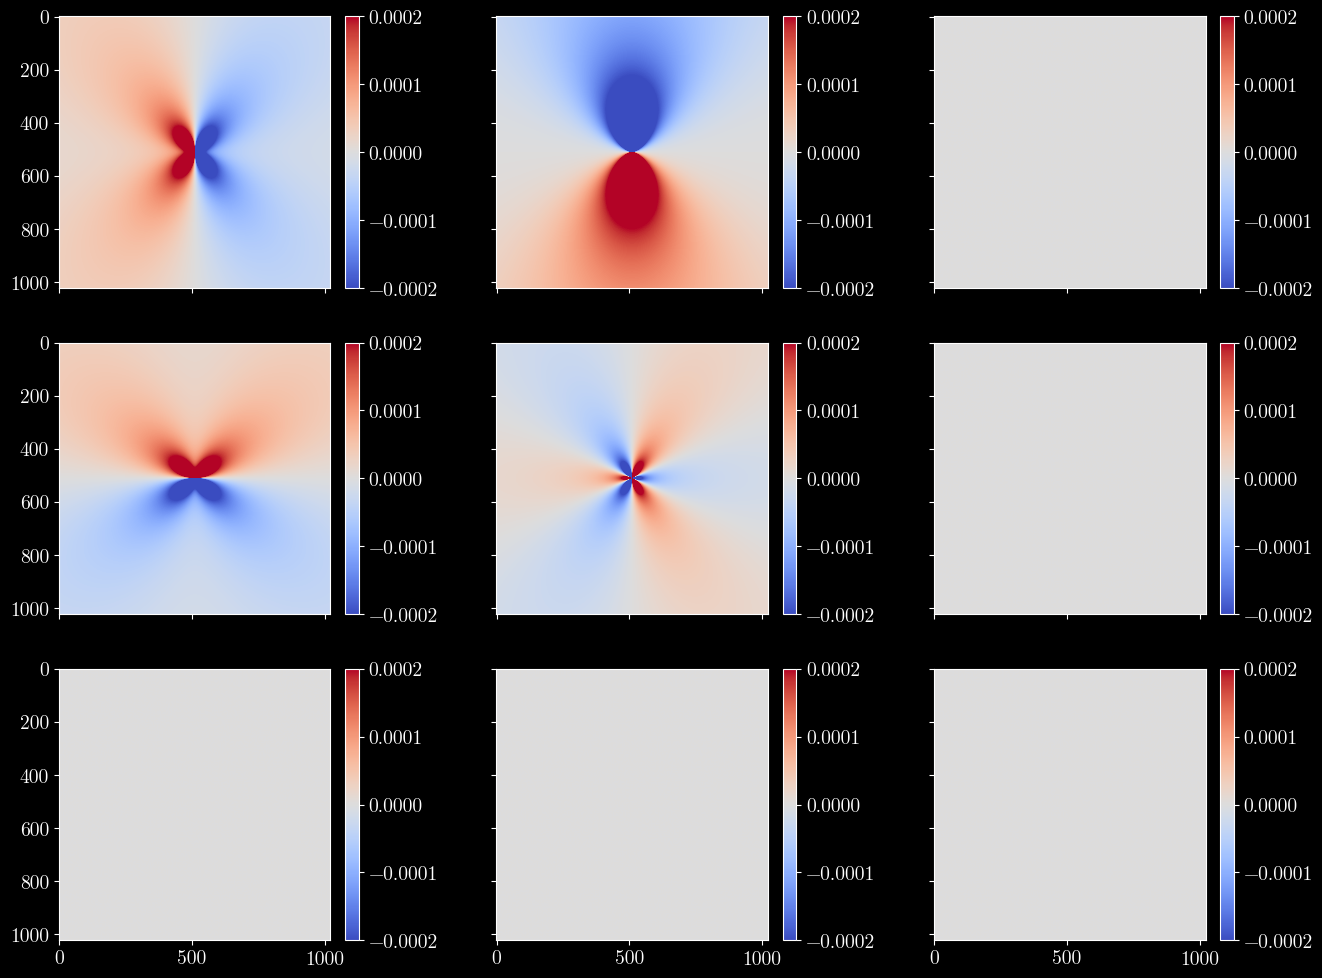

In [140]:
fig, ax = plt.subplots(3, 3, figsize=(16, 12), sharex=True, sharey=True)
for i in range(3):
    for j in range(3):
        im = ax[i, j].imshow(
            beta[:, :, len(zg) // 2, i, j], vmin=-0.0002, vmax=0.0002, cmap="coolwarm"
        )
        fig.colorbar(im, ax=ax[i, j], fraction=0.046, pad=0.04)
plt.show()

In [141]:
np.outer(t / np.linalg.norm(t), b * n / np.linalg.norm(n))

array([[ 6.74108465e-05, -6.74108465e-05, -0.00000000e+00],
       [ 6.74108465e-05, -6.74108465e-05, -0.00000000e+00],
       [ 1.34821693e-04, -1.34821693e-04, -0.00000000e+00]])

In [142]:
alpha = curl(beta, (dx, dy, dz))

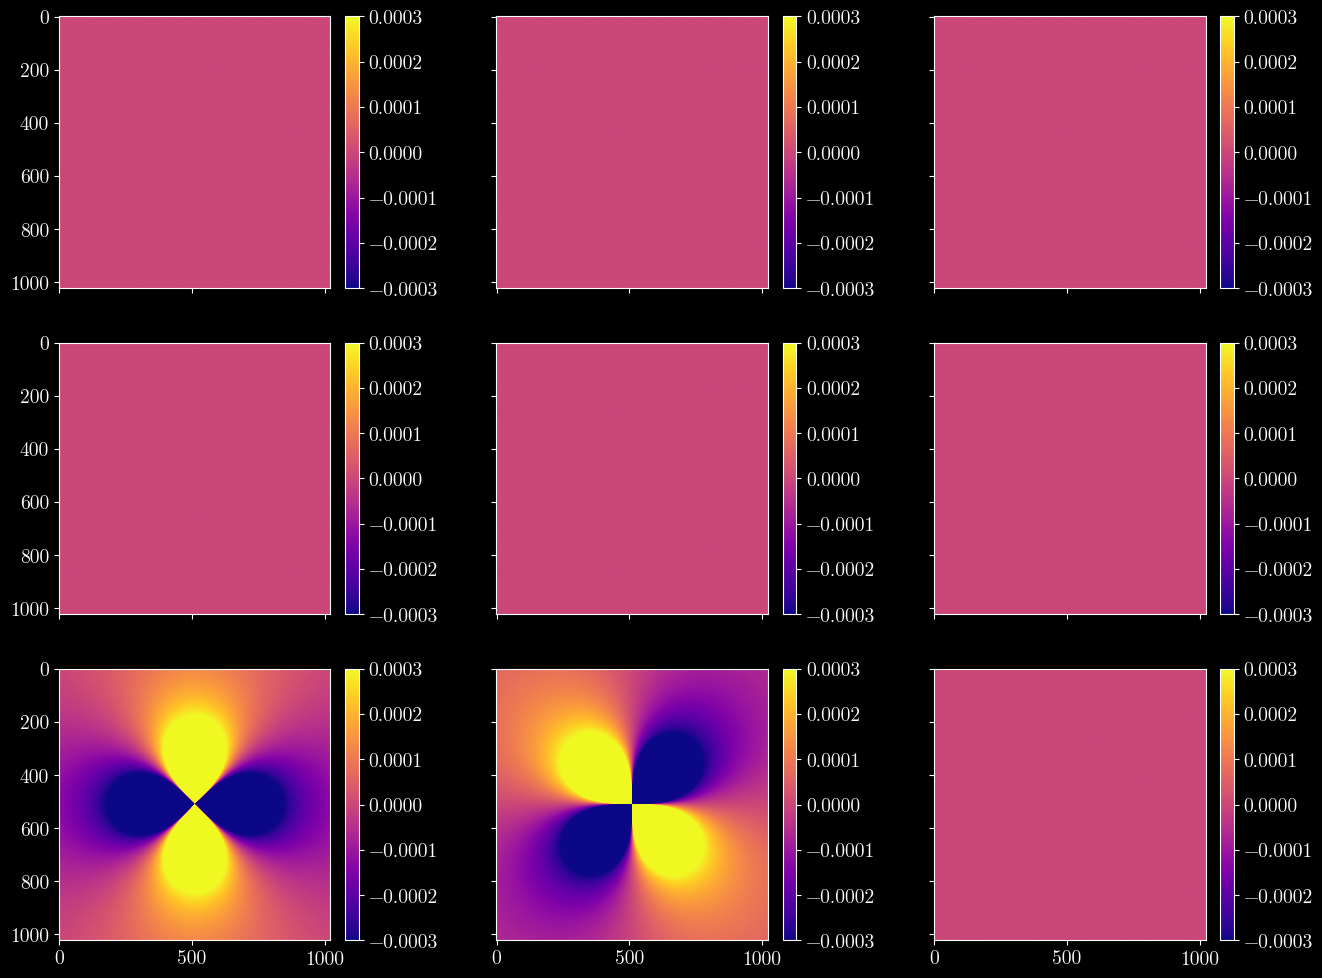

In [143]:
fig, ax = plt.subplots(3, 3, figsize=(16, 12), sharex=True, sharey=True)
for i in range(3):
    for j in range(3):
        im = ax[i, j].imshow(
            alpha[:, :, len(zg) // 2, i, j], vmin=-0.0003, vmax=0.0003, cmap="plasma"
        )
        fig.colorbar(im, ax=ax[i, j], fraction=0.046, pad=0.04)
plt.show()

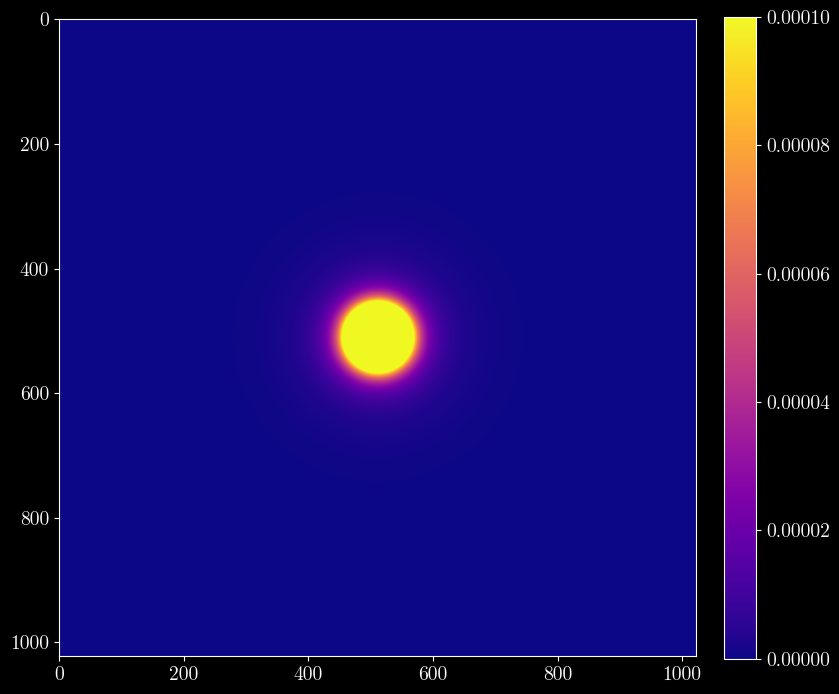

In [145]:
norm_alpha = np.sum(alpha * alpha, axis=(3, 4))
fig, ax = plt.subplots(1, 1, figsize=(9, 9), sharex=True, sharey=True)
im = ax.imshow(
    norm_alpha[:, :, norm_alpha.shape[2] // 2], vmin=0, vmax=0.0001, cmap="plasma"
)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()